In [1]:
from priors import *
from plots import *
from functions import *

xp = gwpop.cupy_utils.xp

from gwpopulation.utils import test
test()

Changed Friday!


In [2]:
luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)
luminosity_prior = luminosity_distances ** 2
dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

### Posteriors

In [3]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

In [4]:
# Sampling pdfs

for posterior in posteriors:
    
    # Joint prior for chi_eff and chi_p is posterior["joint_prior"]
    
    # Mass prior 
    PRIOR_VOLUME = (100. - 2.) ** 2 /2
    posterior["mass_prior"] = (posterior["mass_1"] * (1+posterior["redshift"])**2)/PRIOR_VOLUME
    
    # Redshift prior
    posterior["redshift_prior"] = redshift_prior(posterior['redshift'])

### Spin Gaussian Model without spin selection effects

In [5]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"]

In [6]:
priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [7]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model)

In [8]:
likelihood.parameters.update(priors.sample())

In [9]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 700, label = "nomy_gaussian_spin", 
                           outdir = "Results/nomy_gaussian_spin_less_nlive", clean = True)

00:10 bilby INFO    : Running for label 'nomy_gaussian_spin', output will be saved to 'Results/nomy_gaussian_spin_less_nlive'
00:10 bilby INFO    : Search parameters:
00:10 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
00:10 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
00:10 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
00:10 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
00:10 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
00:10 bilby INFO    : Single likelihood evaluation took 4.472e-03 s


0it [00:00, ?it/s]

00:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 700, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 420, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa898b4c250>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
00:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
00:10 bilby INFO    : Using dynesty version 1.0.1
00:10 bilby INFO    : Using the bilby-implemented rwalk samp

01:06 bilby INFO    : Sampling time: 0:55:59.568099
01:06 bilby INFO    : Summary of results:
nsamples: 9949
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.156
ln_bayes_factor:  7.313 +/-  0.156



mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.005303844936522557
mu_chi_eff mu_chi_p 0.009322995608210226
mu_chi_eff sigma_chi_p 0.012099070114993409
mu_chi_eff spin_covariance 0.015449058457423483


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.012607248268272602
sigma_chi_eff sigma_chi_p 0.01636126274913503
sigma_chi_eff spin_covariance 0.020891366216269754


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.028759509861343915
mu_chi_p spin_covariance 0.036722437743720054


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.04765714451945823


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


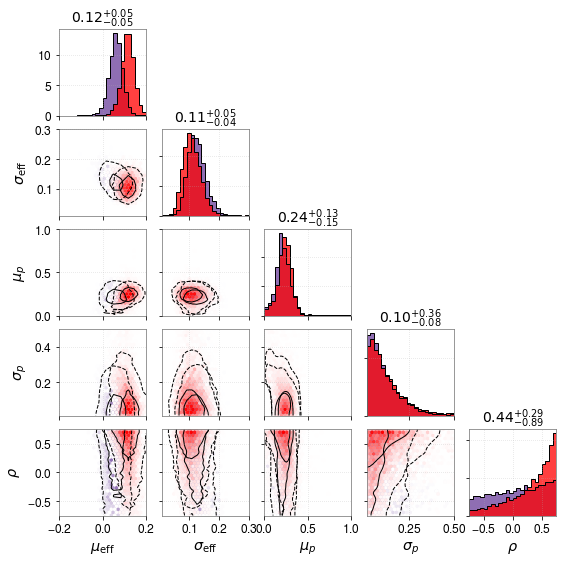

In [10]:
overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/nomy_gaussian_spin_less_nlive/nomy_gaussian_spin_result.json", 
                        "nomy_spin_less_nlive", save = True)

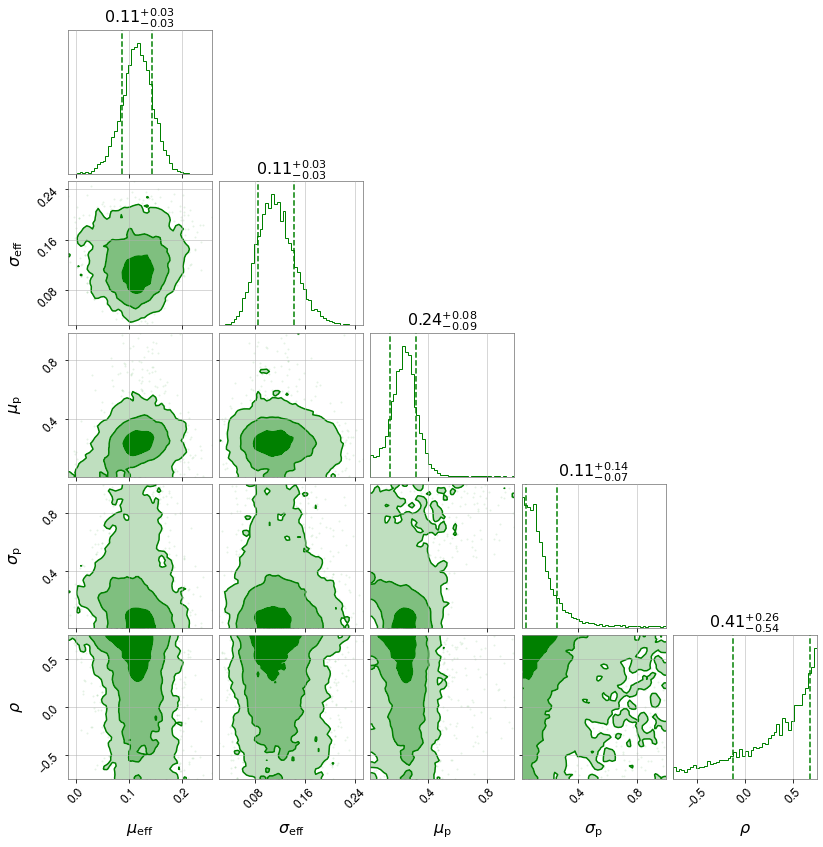

In [10]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.005052166725424984
mu_chi_eff mu_chi_p 0.009255050681605629
mu_chi_eff sigma_chi_p 0.011464685826411638
mu_chi_eff spin_covariance 0.014877439508728324


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.012495245298118941
sigma_chi_eff sigma_chi_p 0.015478474034896177
sigma_chi_eff spin_covariance 0.020086033287635748


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.02835497509335076
mu_chi_p spin_covariance 0.03679555053754665


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.04558045560585076


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


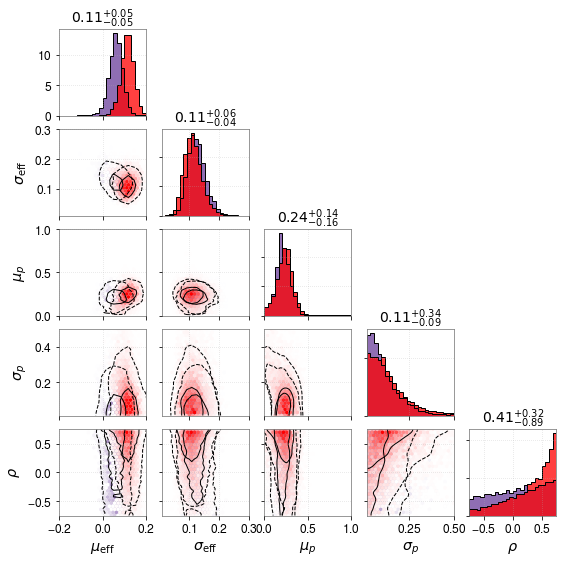

In [5]:
overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/nomy_gaussian_spin/nomy_gaussian_spin_result.json", 
                        "nomy_spin", save = True)

### Spin Gaussian Model with spin selection effects

In [6]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"]

In [7]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff])
    vt_func = injection_resampling_vt_spin
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

13:32 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [8]:
priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [9]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [10]:
likelihood.parameters.update(priors.sample())

In [11]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "nomy_gaussian_spin_vt_spin", 
                           outdir = "Results/nomy_gaussian_spin_vt_spin", clean = True)

13:32 bilby INFO    : Running for label 'nomy_gaussian_spin_vt_spin', output will be saved to 'Results/nomy_gaussian_spin_vt_spin'
13:32 bilby INFO    : Search parameters:
13:32 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
13:32 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
13:32 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
13:32 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
13:32 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
13:32 bilby INFO    : Single likelihood evaluation took 4.251e-03 s


0it [00:00, ?it/s]

13:32 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa9b05d84f0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
13:32 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:32 bilby INFO    : Using dynesty version 1.0.1
13:32 bilby INFO    : Using the bilby-implemented rwalk sam

15:03 bilby INFO    : Sampling time: 1:30:22.464624
15:03 bilby INFO    : Summary of results:
nsamples: 14753
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.132
ln_bayes_factor: 337.367 +/-  0.132



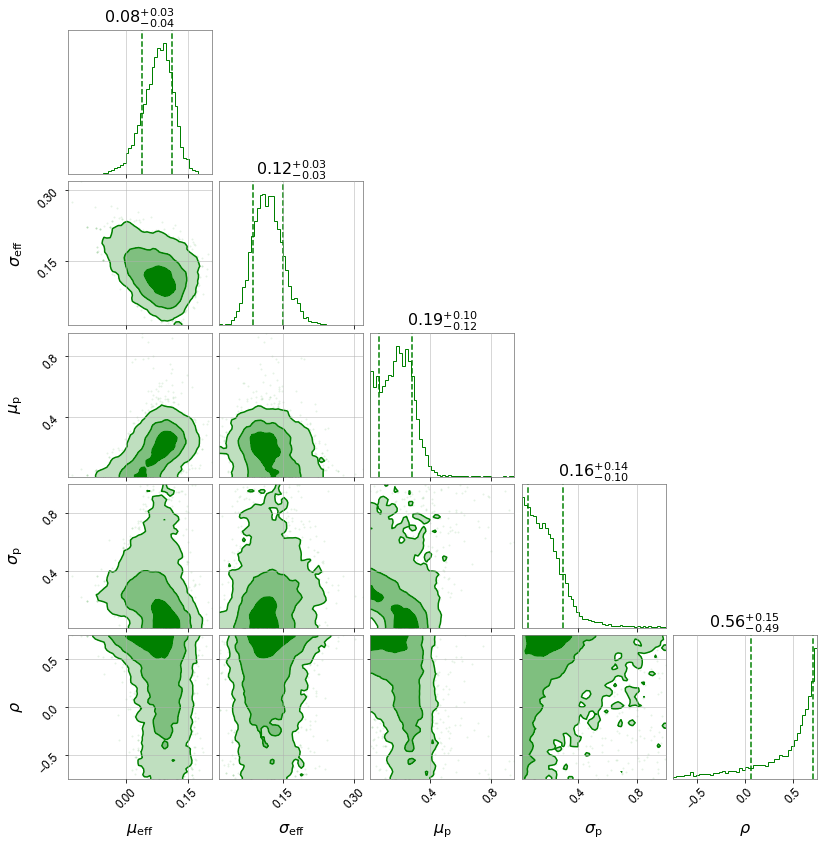

In [12]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.005841765662559642
mu_chi_eff mu_chi_p 0.010397286159878451
mu_chi_eff sigma_chi_p 0.012284090713735676
mu_chi_eff spin_covariance 0.01561085971861782


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.013104396125086284
sigma_chi_eff sigma_chi_p 0.01548246227659546
sigma_chi_eff spin_covariance 0.019675412070058136


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.02755598222314737
mu_chi_p spin_covariance 0.03501867439103773


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.0413735436612537


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


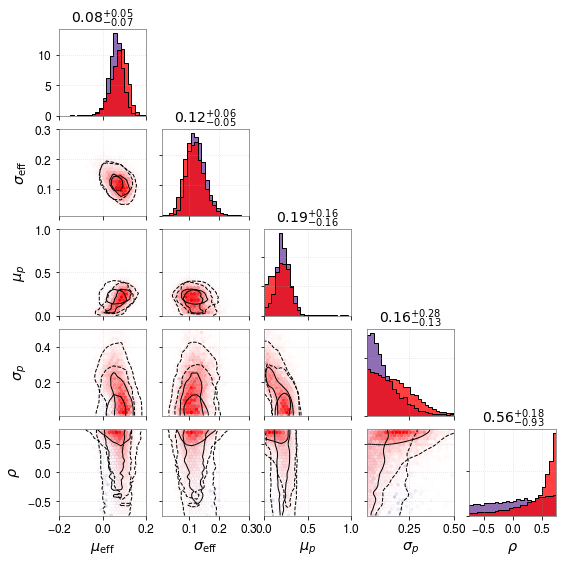

In [13]:
overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/nomy_gaussian_spin_vt_spin/nomy_gaussian_spin_vt_spin_result.json", 
                        "nomy_spin_vt_spin", save = True)

### Full Gaussian Model without selection effects

In [5]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"] * posterior["redshift_prior"]

In [6]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [8]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model)

In [9]:
likelihood.parameters.update(priors.sample())

In [ ]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian", 
                           outdir = "gaussian", clean = True)

00:07 bilby INFO    : Running for label 'gaussian', output will be saved to 'gaussian'
00:07 bilby INFO    : Search parameters:
00:07 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
00:07 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
00:07 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
00:07 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
00:07 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
00:07 bilby INFO    :   alpha = -2.2
00:07 bilby INFO    :   beta = 1.3
00:07 bilby INFO    :   mmin = 5
00:07 bilby INFO    :   mmax = 75
00:07 bilby INFO    

0it [00:00, ?it/s]

00:07 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc170d32d60>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
00:07 bilby INFO    : Checkpoint every check_point_delta_t = 600s
00:07 bilby INFO    : Using dynesty version 1.0.1
00:07 bilby INFO    : Using the bilby-implemented rwalk sam

In [ ]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.004841109604184614
mu_chi_eff mu_chi_p 0.007946740236874063
mu_chi_eff sigma_chi_p 0.008797778073950685
mu_chi_eff spin_covariance 0.01404101167371983


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.010731025025362223
sigma_chi_eff sigma_chi_p 0.011880239427114423
sigma_chi_eff spin_covariance 0.018960535157917787


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.01950155736972808
mu_chi_p spin_covariance 0.031123948840540375


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.03445709643477408


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


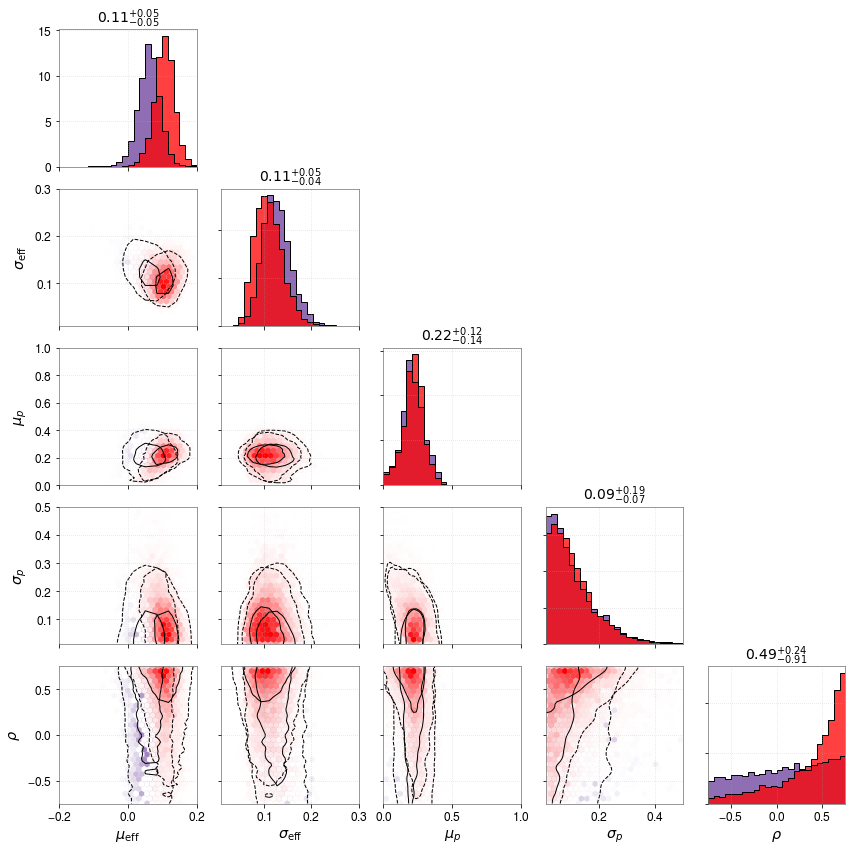

In [11]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian/gaussian_result.json", "spin_mass_redshift", save = True)

### Full Gaussian Model with only mass selection effects

In [5]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"] * posterior["redshift_prior"]

In [6]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**(-2.35+1) * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

In [7]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([mass.power_law_primary_mass_ratio])
    vt_func = injection_resampling_vt_mass
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

16:37 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [8]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [9]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [10]:
likelihood.parameters.update(priors.sample())

In [11]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_mass_vt", 
                           outdir = "gaussian_mass_vt", clean = True)

16:38 bilby INFO    : Running for label 'gaussian_mass_vt', output will be saved to 'gaussian_mass_vt'
16:38 bilby INFO    : Search parameters:
16:38 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
16:38 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
16:38 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
16:38 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
16:38 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
16:38 bilby INFO    :   alpha = -2.2
16:38 bilby INFO    :   beta = 1.3
16:38 bilby INFO    :   mmin = 5
16:38 bilby INFO    :   mmax = 75
16:3

0it [00:00, ?it/s]

16:38 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff7ac46c970>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
16:38 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:38 bilby INFO    : Using dynesty version 1.0.1
16:38 bilby INFO    : Using the bilby-implemented rwalk sam

17:55 bilby INFO    : Sampling time: 1:16:35.408962
17:55 bilby INFO    : Summary of results:
nsamples: 14282
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.132
ln_bayes_factor: -907.748 +/-  0.132



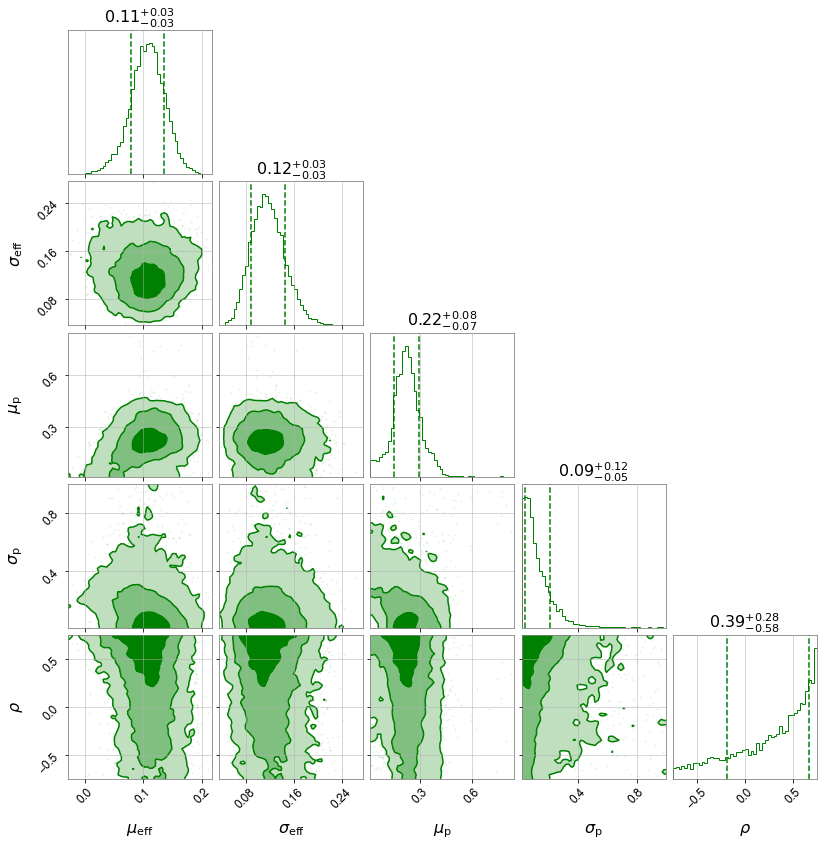

In [12]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.004958416899271591
mu_chi_eff mu_chi_p 0.008475921597583865
mu_chi_eff sigma_chi_p 0.009784968697999658
mu_chi_eff spin_covariance 0.015157874389682368


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.011217498367365113
sigma_chi_eff sigma_chi_p 0.012949962919173148
sigma_chi_eff spin_covariance 0.020060760267940295


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.022136676407878177
mu_chi_p spin_covariance 0.03429187877363961


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.03958802078718053


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


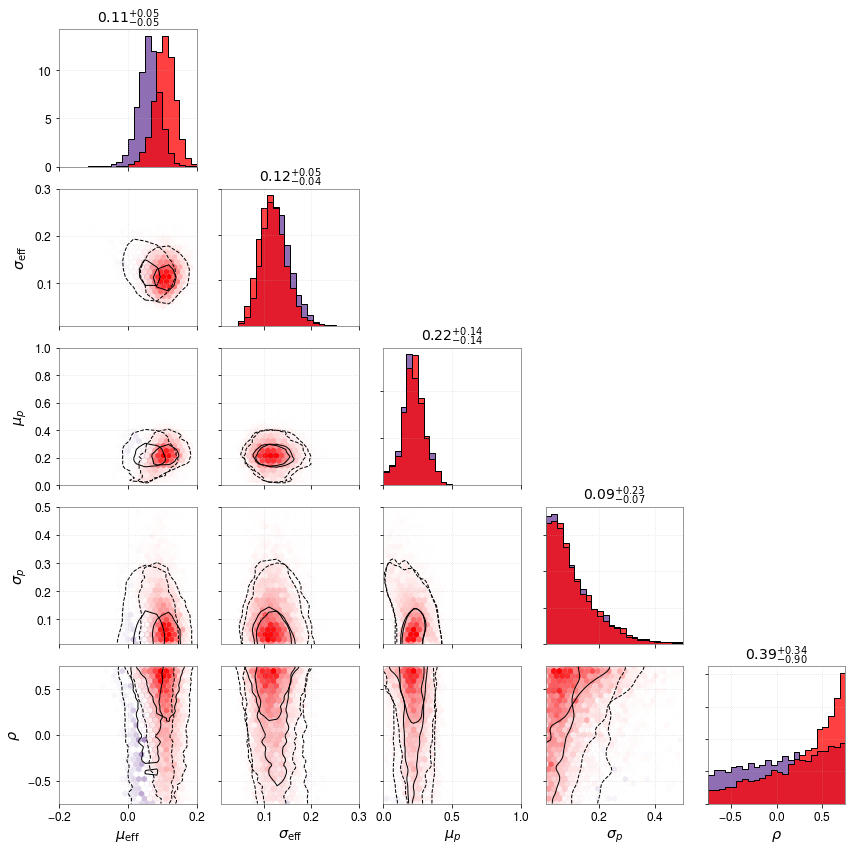

In [13]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_mass_vt/gaussian_mass_vt_result.json", 
               "spin_mass_redshift_mass_vt", save = True)

### Full Gaussian Model with mass and redshift selection effects

In [14]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"] * posterior["redshift_prior"]

In [15]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**(-2.35+1) * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

In [16]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([mass.power_law_primary_mass_ratio,
                      redshift.PowerLawRedshift()])
    vt_func = injection_resampling_vt_mass_redshift
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

20:59 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [17]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [18]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [19]:
likelihood.parameters.update(priors.sample())

In [20]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_mass_redshift_vt", 
                           outdir = "gaussian_mass_redshift_vt", clean = True)

20:59 bilby INFO    : Running for label 'gaussian_mass_redshift_vt', output will be saved to 'gaussian_mass_redshift_vt'
20:59 bilby INFO    : Search parameters:
20:59 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
20:59 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
20:59 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
20:59 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
20:59 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
20:59 bilby INFO    :   alpha = -2.2
20:59 bilby INFO    :   beta = 1.3
20:59 bilby INFO    :   mmin = 5
20:59 bilby INFO    

0it [00:00, ?it/s]

20:59 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff667f90880>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
20:59 bilby INFO    : Checkpoint every check_point_delta_t = 600s
20:59 bilby INFO    : Using dynesty version 1.0.1
20:59 bilby INFO    : Using the bilby-implemented rwalk sam

22:18 bilby INFO    : Sampling time: 1:18:34.813878
22:18 bilby INFO    : Summary of results:
nsamples: 14478
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.134
ln_bayes_factor: -1211.594 +/-  0.134



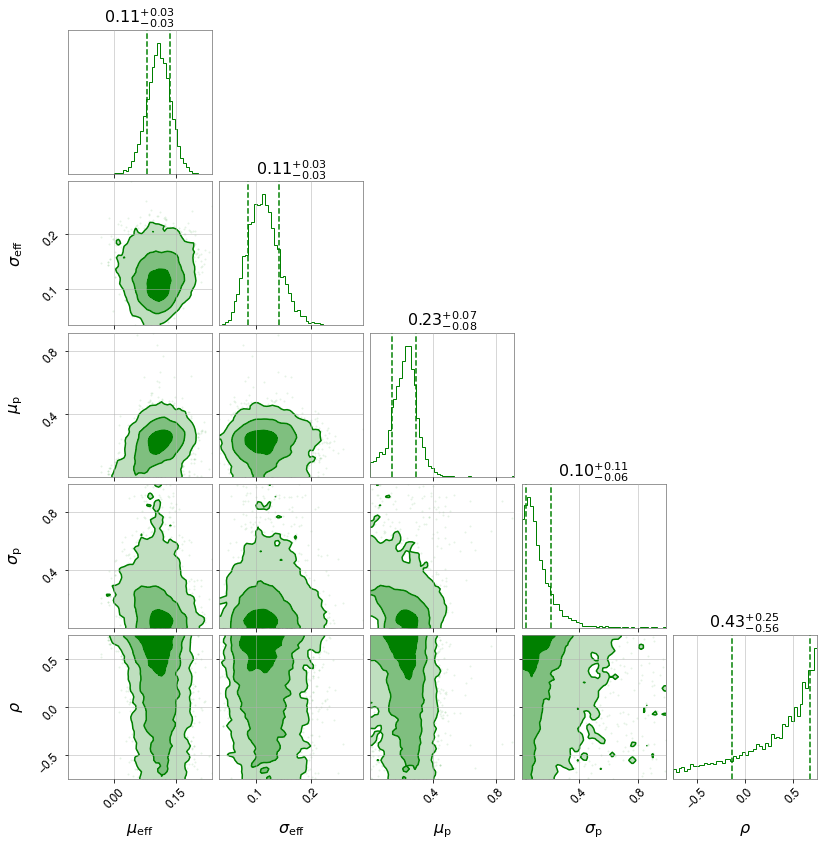

In [21]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.004900847763780432
mu_chi_eff mu_chi_p 0.00827797394286198
mu_chi_eff sigma_chi_p 0.009655175262681942
mu_chi_eff spin_covariance 0.014733765256013373


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.011123560331727596
sigma_chi_eff sigma_chi_p 0.01297418006980517
sigma_chi_eff spin_covariance 0.019798555524579674


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.021914560444334208
mu_chi_p spin_covariance 0.033441546164729906


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.03900519517266133


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


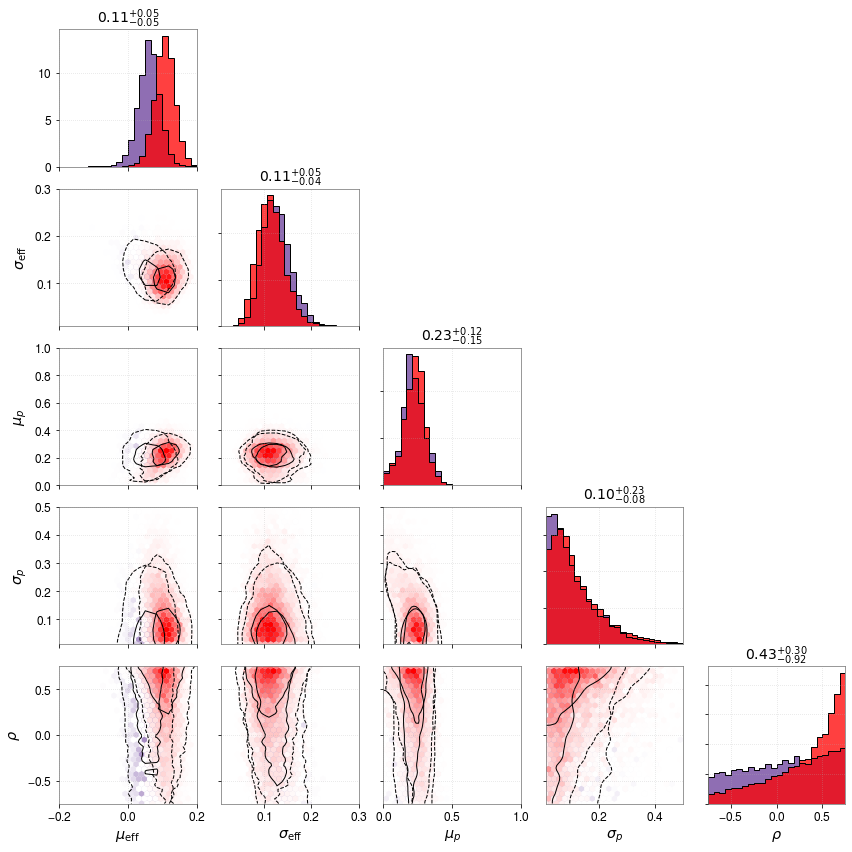

In [22]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_mass_redshift_vt/gaussian_mass_redshift_vt_result.json", 
               "spin_mass_redshift_mass_redshift_vt", save = True)

### Full Gaussian Model with mass, spin and redshift selection effects

In [5]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"] * posterior["redshift_prior"]

In [6]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**(-2.35+1) * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

In [7]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff, 
                      mass.power_law_primary_mass_ratio,
                      redshift.PowerLawRedshift()])
    vt_func = injection_resampling_vt_spin_mass_redshift
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

01:22 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [8]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [9]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [10]:
likelihood.parameters.update(priors.sample())

In [11]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "nomygaussian_mass_spin_redshift_vt_mass_spin_redshift", 
                           outdir = "nomygaussian_mass_spin_redshift_vt_mass_spin_redshift", clean = True)

01:23 bilby INFO    : Running for label 'nomygaussian_mass_spin_redshift_vt_mass_spin_redshift', output will be saved to 'nomygaussian_mass_spin_redshift_vt_mass_spin_redshift'
01:23 bilby INFO    : Search parameters:
01:23 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
01:23 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
01:23 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
01:23 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
01:23 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
01:23 bilby INFO    :   alpha = -2.2
01:23 bilby INFO    :   beta = 1

0it [00:00, ?it/s]

01:23 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc578235370>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
01:23 bilby INFO    : Checkpoint every check_point_delta_t = 600s
01:23 bilby INFO    : Using dynesty version 1.0.1
01:23 bilby INFO    : Using the bilby-implemented rwalk sam

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


03:43 bilby INFO    : Sampling time: 2:19:18.751356
03:43 bilby INFO    : Summary of results:
nsamples: 15214
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.136
ln_bayes_factor: -1238.875 +/-  0.136



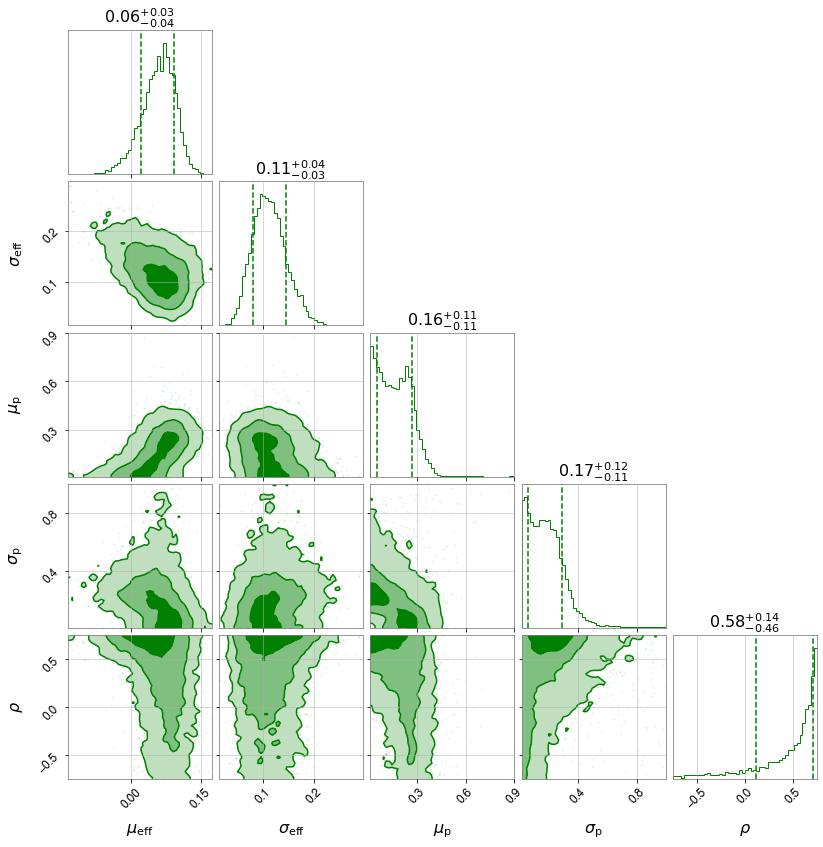

In [12]:
result.plot_corner(color = 'g')

In [13]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "nomygaussian_mass_spin_redshift_vt_mass_spin_redshift/nomygaussian_mass_spin_redshift_vt_mass_spin_redshift_result.json", 
               "nomyspin_mass_redshift_vt_mass_spin_redshift", save = True)

NameError: name 'overlayed_plot' is not defined

### Gaussian Spin model with PowerLaw + Peak Mass model with Powerlaw redshift model